<a href="https://colab.research.google.com/github/thabied/thabied.github.io/blob/master/COVID_X_Ray_using_TensorFlow_js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 X-RAY IMAGING CLASSIFICATION**

In [ ]:
# IMPORT PACKAGES AND LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNet

from IPython.display import display, Image
import matplotlib.pyplot as mpimg
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# CREATE CONFIG PATH TO KAGGLE.JSON FILE
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Deployment Models/Corona X-Rays"

# SET WORKING DIRECTORY
!cd '/content/drive/My Drive/Deployment Models/Corona X-Rays'

In [ ]:
# DOWNLOAD DATASET
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset 

100% 1.19G/1.19G [00:16<00:00, 118MB/s]
100% 1.19G/1.19G [00:16<00:00, 76.3MB/s]


In [ ]:
# UNZIP FILE
!unzip coronahack-chest-xraydataset.zip

In [ ]:
!ls

Chest_xray_Corona_dataset_Summary.csv  coronahack-chest-xraydataset.zip
Chest_xray_Corona_Metadata.csv	       drive
Coronahack-Chest-XRay-Dataset	       sample_data


# **EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

In [ ]:
# EXPLORE METADATA
meta = pd.read_csv('/content/drive/My Drive/Deployment Models/Corona X-Rays/Chest_xray_Corona_Metadata.csv')

In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


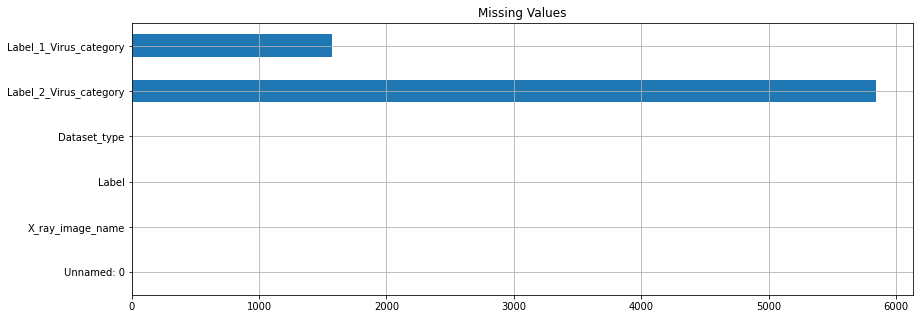

In [ ]:
missing_values = meta.isnull().sum()
missing_values.plot(kind='barh',figsize=(14,5),title='Missing Values',grid=True)

In [ ]:
# REPLACE NANS WITH 'UNKNOWN'
meta = meta.fillna('unknown')

In [ ]:
meta.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown


In [ ]:
train_entries = len(meta[meta['Dataset_type'] == 'TRAIN']) / len(meta)
test_entries = len(meta[meta['Dataset_type'] == 'TEST']) / len(meta)

print('train percentage %: ',round(train_entries,3))
print('test percentage %: ',round(test_entries,3))

train percentage %:  0.894
test percentage %:  0.106


In [ ]:
normal_entries = len(meta[meta['Label'] == 'Normal']) / len(meta)
pneumonia_entries = len(meta[meta['Label'] == 'Pnemonia']) / len(meta)

print('Normal percentage %: ',round(normal_entries,3))
print('Pneumonia percentage %: ',round(pneumonia_entries,3))

Normal percentage %:  0.267
Pneumonia percentage %:  0.733


In [ ]:
# SET SHAPE OF TRAIN AND TEST
train = meta[meta['Dataset_type'] == 'TRAIN']
test = meta[meta['Dataset_type'] == 'TEST']
assert train.shape[0] + test.shape[0] == meta.shape[0]

print(f"Shape of train data : {train.shape}")
print(f"Shape of test data : {test.shape}")

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


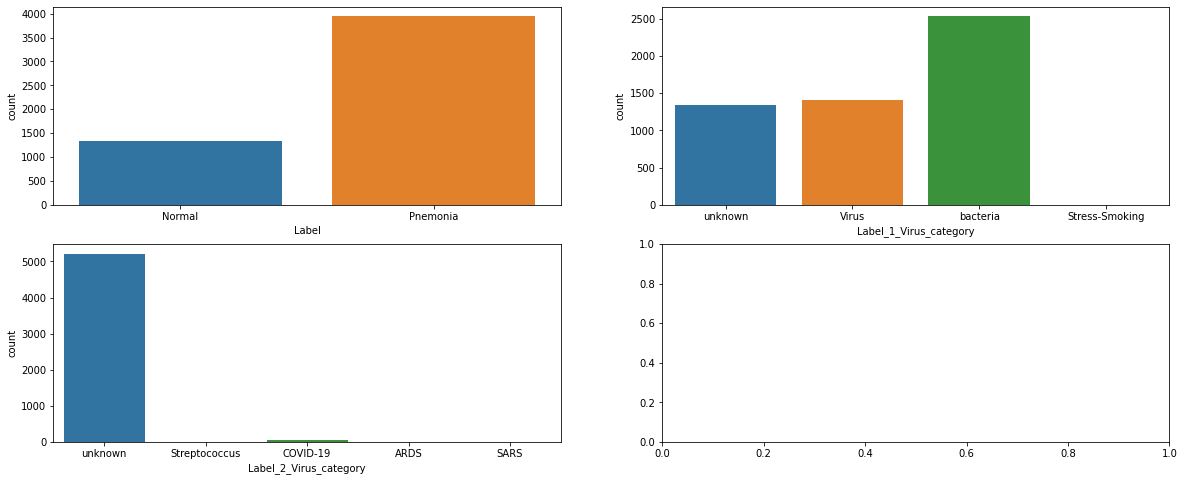

In [ ]:
targets = ['Label', 'Label_1_Virus_category','Label_2_Virus_category']
fig, ax = plt.subplots(2,2, figsize=(20, 8))
sns.countplot(x=targets[0], data=train, ax=ax[0,0], orient='v')
sns.countplot(x=targets[1], data=train, ax=ax[0,1], orient='v')
sns.countplot(x=targets[2], data=train, ax=ax[1,0], orient='v')
plt.show()

In [ ]:
# CREATE PATHS TO IMAGES
train_img_dir = '/content/drive/My Drive/Deployment Models/Corona X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_img_dir = '//content/drive/My Drive/Deployment Models/Corona X-Rays/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

assert os.path.isdir(test_img_dir) == True
assert os.path.isdir(train_img_dir) == True

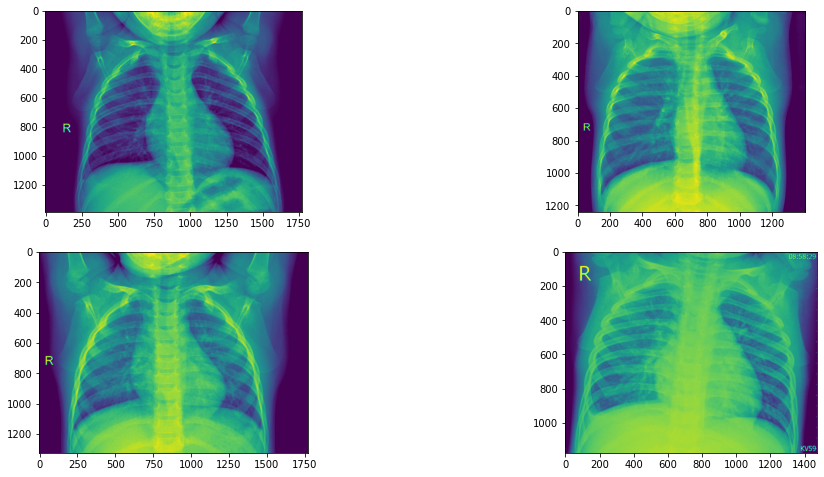

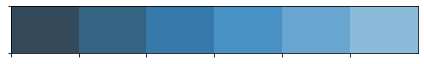

In [ ]:
# SELECT SAMPLES TO VISUALIZE
sample_train_images = list(os.walk(train_img_dir))[0][2][:4]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

from PIL import Image
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

sns.palplot(sns.color_palette("Blues_d"))
plt.tight_layout()

In [ ]:
# SELECT ONLY COVID-19 AND NON-COVID-19 ENTRIES
train = train[(train['Label'] == 'Normal') | 
                              ((train['Label'] == 'Pnemonia') & (train['Label_2_Virus_category'] == 'COVID-19'))]

In [ ]:
# CREATE TARGET VARIABLE
train['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in train['Label']]

final_train_data = shuffle(train, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")

Final train data shape : (1000, 7)


# **MODEL DEVELOPMENT AND TRAINING**

In [ ]:
# DATA AUGMENTATION WITH GENERATORS
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [ ]:
# SAVE CLASS INDICES AS JSON FILE
import json
classes_dict = train_generator.class_indices
with open('/content/drive/My Drive/Deployment Models/Corona X-Rays/model 4/class_indices.json','w') as f:
    json.dump(classes_dict, f)

## **CNN MODEL WITH DROPOUT, BATCH NORMALIZATION AND MAX POOLING**

In [ ]:
# CREATE MODEL
i = Input(shape=(224,224,3))
x = Conv2D(32, (3, 3), activation='relu',padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [ ]:
# COMPILE MODEL
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# FIT MODEL
cnn = model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                validation_data = validation_generator,
                epochs = epochs,
                validation_steps = validation_generator.samples // batch_size,
                )

Text(0.5, 1.0, 'Metrics estimations')

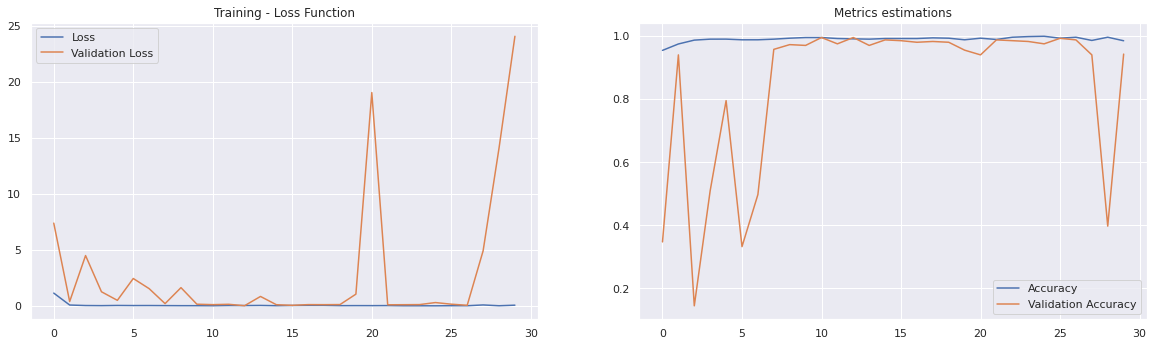

In [ ]:
# VISUALIZE PERFORMANCE
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.plot(cnn.history['loss'], label='Loss')
plt.plot(cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn.history['accuracy'], label='Accuracy')
plt.plot(cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')

In [ ]:
# SAVE MODEL
tf.saved_model.save(model, '/content/drive/My Drive/Deployment Models/Corona X-Rays/model1')

In [ ]:
# LOAD MODEL
model = tf.saved_model.load('/content/drive/My Drive/Deployment Models/Corona X-Rays/model1')

## **USING MOBILENET MODEL FOR TRANSFER LEARNING**

In [ ]:
from keras import Input, Model
from keras.applications import MobileNet
from keras.layers.core import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

### **FIRST IMPLEMENT**

In [ ]:
# USING MOBILENETV2
mob_model = Sequential()
mob_model.add(tf.keras.applications.MobileNetV2(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
mob_model.add(Dense(32, activation='relu'))
mob_model.add(Dense(1, activation='sigmoid'))
mob_model.layers[0].trainable = False

In [ ]:
# COMPILE MODEL
mob_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# FIT MODEL
mob_history = mob_model.fit_generator(train_generator,
                                      steps_per_epoch = len(train_generator),
                                      validation_data=validation_generator,
                                      epochs=20,
                                      validation_steps=len(validation_generator),
                                     )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
63/63 [==============================] - 76s 1s/step - loss: 0.1643 - accuracy: 0.9510 - val_loss: 0.0924 - val_accuracy: 0.9425
Epoch 2/20
63/63 [==============================] - 77s 1s/step - loss: 0.0589 - accuracy: 0.9660 - val_loss: 0.0595 - val_accuracy: 0.9650
Epoch 3/20
63/63 [==============================] - 80s 1s/step - loss: 0.0392 - accuracy: 0.9880 - val_loss: 0.0373 - val_accuracy: 0.9850
Epoch 4/20
63/63 [==============================] - 80s 1s/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.0347 - val_accuracy: 0.9825
Epoch 5/20
63/63 [==============================] - 74s 1s/step - loss: 0.0212 - accuracy: 0.9910 - val_loss: 0.0225 - val_accuracy: 0.9875
Epoch 6/20
63/63 [==============================] - 73s 1s/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0164 - val_accuracy: 0.9950
Epoch 7/20
63/63 [==============================] - 72s 1s/step - loss: 0.0103 - acc

Text(0.5, 1.0, 'Metrics estimations')

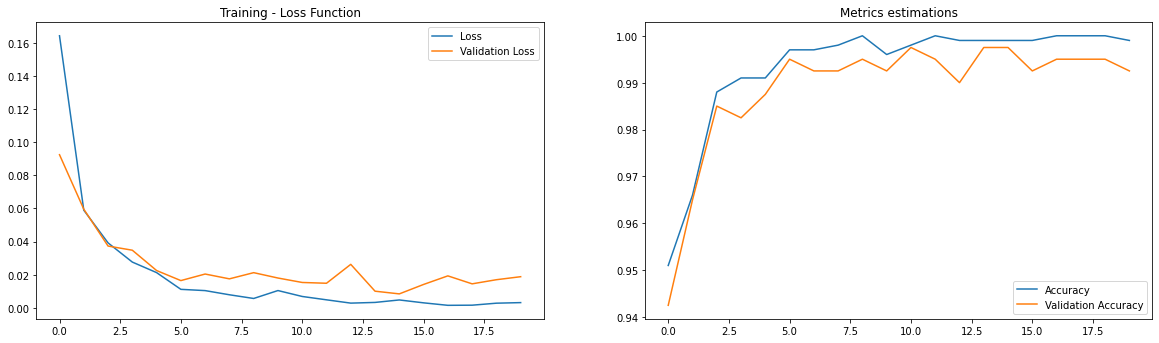

In [ ]:
# VISUALIZE PERFORMANCE
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.plot(mob_history.history['loss'], label='Loss')
plt.plot(mob_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(mob_history.history['accuracy'], label='Accuracy')
plt.plot(mob_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')

In [ ]:
# SAVE MODEL
mob_model.save('/content/drive/My Drive/Deployment Models/Corona X-Rays/model2/mob_model.h5')

In [ ]:
# LOAD MODEL
mob_model = keras.models.load_model('/content/drive/My Drive/Deployment Models/Corona X-Rays/model2/mob_model.h5')

### **SECOND IMPLEMENTATION**

In [ ]:
base_model = MobileNet(
    #Load weights into the pre-trained MobileNet model
    weights="imagenet",
    input_shape=(224, 224, 3),
    #Exclude the ImageNet classifier at the top of the model
    include_top=False
)  

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
# Regularization by applying DropOut
head_model = Dropout(0.2)(head_model)
outputs = Dense(1, activation='sigmoid')(head_model)
mobilenet_model = Model(base_model.input, outputs, name='pretrained_mobilenet' )

# or if we want to set the first 20 layers of the network to be non-trainable
for layer in mobilenet_model.layers[:20]:
    layer.trainable=False
for layer in mobilenet_model.layers[20:]:
    layer.trainable=True

In [ ]:
# Compiling the model with the optimizer and loss function 

mobilenet_model.compile(optimizer = Adam(),
              loss = "binary_crossentropy",
              metrics = ['accuracy']
)

In [ ]:
history = mobilenet_model.fit(train_generator,
          validation_data = validation_generator,
          epochs = 10,
          steps_per_epoch = len(train_generator),
          validation_steps = len(validation_generator), 
          )

Epoch 1/10
63/63 [==============================] - 548s 9s/step - loss: 0.0747 - accuracy: 0.9730 - val_loss: 0.3983 - val_accuracy: 0.9650
Epoch 2/10
63/63 [==============================] - 45s 720ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0924 - val_accuracy: 0.9850
Epoch 3/10
63/63 [==============================] - 45s 713ms/step - loss: 0.0148 - accuracy: 0.9970 - val_loss: 0.0202 - val_accuracy: 0.9975
Epoch 4/10
63/63 [==============================] - 45s 717ms/step - loss: 0.0415 - accuracy: 0.9890 - val_loss: 0.2432 - val_accuracy: 0.9650
Epoch 5/10
63/63 [==============================] - 45s 712ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.3595 - val_accuracy: 0.9625
Epoch 6/10
63/63 [==============================] - 45s 707ms/step - loss: 6.5344e-04 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.9875
Epoch 7/10
63/63 [==============================] - 44s 699ms/step - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0564 - val_accuracy: 0.99

Text(0.5, 1.0, 'Metrics estimations')

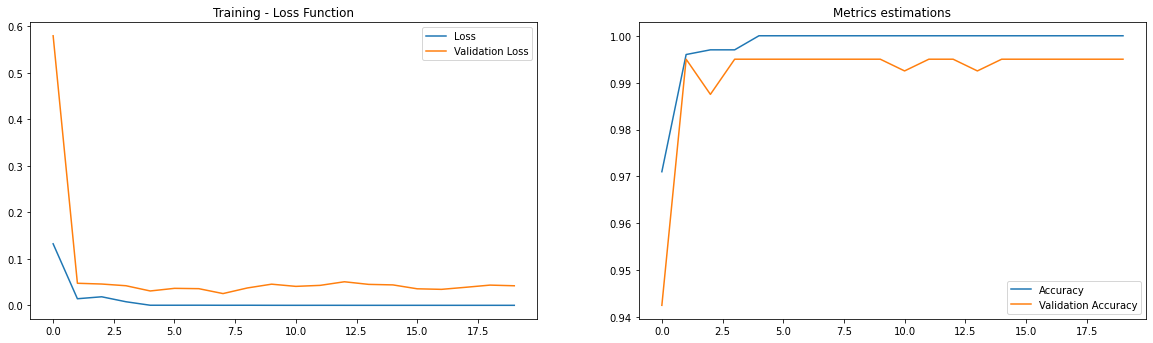

In [ ]:
# VISUALIZE PERFORMANCE
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')

In [ ]:
# SAVE MODEL
mobilenet_model.save('/content/drive/My Drive/Deployment Models/Corona X-Rays/model3/mob_model.h5')

In [ ]:
model = model.load('/content/drive/My Drive/Deployment Models/Corona X-Rays/model3/mob_model.h5')

NameError: ignored

# **CONVERT BEST MODEL TO TENSORFLOW.JS MODEL**

In [ ]:
!pip install tensorflowjs

## **TENSORFLOW CONVERSION**

In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive
%cd My Drive
%cd Deployment Models
%cd Corona X-Rays

/content/drive
/content/drive/My Drive
/content/drive/My Drive/Deployment Models
/content/drive/My Drive/Deployment Models/Corona X-Rays


In [ ]:
# CONVERT TO TENSORFLOW.JS MODEL
!tensorflowjs_converter --input_format tf_saved_model model1 tensorflowjs_model2

In [ ]:
!zip -r tensorflowjs_model2.zip tensorflowjs_model2

  adding: tensorflowjs_model2/ (stored 0%)
  adding: tensorflowjs_model2/group1-shard1of3.bin (deflated 7%)
  adding: tensorflowjs_model2/group1-shard2of3.bin (deflated 7%)
  adding: tensorflowjs_model2/group1-shard3of3.bin (deflated 7%)
  adding: tensorflowjs_model2/model.json (deflated 93%)


## **MOBILENET CONVERSION**

In [ ]:
%cd /content

/content


In [ ]:
!pwd

/root


In [ ]:
!ls

In [ ]:
# %cd content
# %cd drive
# %cd My Drive
# %cd Deployment Models
%cd Corona X-Rays

/content/drive/My Drive/Deployment Models/Corona X-Rays


In [ ]:
# CONVERT TO TENSORFLOW.JS MODEL
!tensorflowjs_converter --input_format keras model3/mob_model.h5 tensorflowjs_model1

In [ ]:
!zip -r tensorflowjs_model1.zip tensorflowjs_model1

  adding: tensorflowjs_model1/ (stored 0%)
  adding: tensorflowjs_model1/group1-shard1of4.bin (deflated 7%)
  adding: tensorflowjs_model1/group1-shard2of4.bin (deflated 7%)
  adding: tensorflowjs_model1/group1-shard3of4.bin (deflated 7%)
  adding: tensorflowjs_model1/group1-shard4of4.bin (deflated 7%)
  adding: tensorflowjs_model1/model.json (deflated 94%)
